## ADAS Implementation Plan
#### 1. Data Acquisition and Preprocessing

Camera Data Preprocessing

Implement transfer learning using a pre-trained model (ResNet50 or EfficientNet)
Fine-tune for specific ADAS-relevant object classes
Apply data augmentation to improve robustness
Extract object vectors with bounding boxes, class labels, and confidence scores

In [2]:
def preprocess_camera_data(image):
    # Normalize image
    normalized_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0
    
    # Apply object detection (using fine-tuned model instead of generic YOLOv5)
    # For transfer learning, you would modify this to use your custom model
    results = self.camera_model(normalized_img)
    
    # Extract object data with additional attributes
    objects = []
    for obj in results.pandas().xyxy[0].to_dict('records'):
        # Calculate additional features (e.g., object area, aspect ratio)
        width = obj['xmax'] - obj['xmin']
        height = obj['ymax'] - obj['ymin']
        area = width * height
        aspect_ratio = width / height if height > 0 else 0
        
        # Store enhanced object data
        objects.append({
            **obj,
            'area': area,
            'aspect_ratio': aspect_ratio,
            'centroid': ((obj['xmin'] + obj['xmax']) / 2, (obj['ymin'] + obj['ymax']) / 2)
        })
    
    return objects

LIDAR Data Preprocessing

Convert point cloud to structured format
Apply ground plane removal
Cluster points to identify distinct objects
Calculate geometric features (dimensions, orientation)

In [3]:
def preprocess_lidar_data(point_cloud):
    # Remove ground plane points
    non_ground_points = remove_ground_plane(point_cloud)
    
    # Cluster remaining points into objects
    clustered_objects = dbscan_clustering(non_ground_points)
    
    # Extract features for each object
    lidar_objects = []
    for cluster in clustered_objects:
        # Calculate bounding box, dimensions, orientation
        bbox, dimensions, orientation = calculate_object_geometry(cluster)
        
        # Calculate distance from vehicle
        distance = np.min(np.linalg.norm(cluster, axis=1))
        
        lidar_objects.append({
            'points': cluster,
            'bbox': bbox,
            'dimensions': dimensions,
            'orientation': orientation,
            'distance': distance
        })
    
    return lidar_objects

Radar Data Preprocessing

Filter noise and clutter
Apply tracking algorithms (e.g., JPDA)
Extract velocity and distance information

In [4]:
def preprocess_radar_data(radar_signals):
    # Filter noise and clutter
    filtered_signals = apply_cfar_detection(radar_signals)
    
    # Track objects over time (JPDA or similar algorithm)
    tracked_objects = radar_tracking(filtered_signals)
    
    # Extract features
    radar_objects = []
    for obj in tracked_objects:
        radar_objects.append({
            'distance': obj.distance,
            'radial_velocity': obj.velocity,
            'angle': obj.angle,
            'rcs': obj.radar_cross_section,  # For object classification
            'tracking_id': obj.id
        })
    
    return radar_objects

### 2. Sensor Fusion Enhancement
Spatial Registration

Calibrate sensors to common coordinate system
Implement projection functions between sensors

In [5]:
def project_lidar_to_camera(lidar_point, calibration_matrix):
    """Project a LIDAR point to camera image plane"""
    # Convert point to homogeneous coordinates
    point_homogeneous = np.append(lidar_point, 1)
    
    # Apply projection matrix
    projected_point = np.dot(calibration_matrix, point_homogeneous)
    
    # Convert to image coordinates
    pixel_x = projected_point[0] / projected_point[2]
    pixel_y = projected_point[1] / projected_point[2]
    
    return pixel_x, pixel_y

Improved Fusion Algorithm

Implement Kalman filtering for object tracking
Use IoU (Intersection over Union) for object matching
Apply confidence weighting based on sensor reliability

In [6]:
def improved_sensor_fusion(camera_objects, lidar_objects, radar_objects):
    # Initialize object tracker if not already created
    if not hasattr(self, 'object_tracker'):
        self.object_tracker = KalmanFilterTracker()
    
    # Match objects across sensors using IoU and spatial proximity
    matched_objects = match_objects_across_sensors(
        camera_objects, 
        lidar_objects, 
        radar_objects
    )
    
    # Update tracker with new observations
    tracked_objects = self.object_tracker.update(matched_objects)
    
    # Enhance object attributes with sensor-specific information
    enhanced_objects = []
    for obj in tracked_objects:
        # Calculate confidence based on sensor agreement
        sensor_confidence = calculate_sensor_agreement_confidence(obj)
        
        # Merge attributes from all sensors
        merged_attributes = merge_sensor_attributes(obj)
        
        enhanced_objects.append({
            **merged_attributes,
            'tracking_id': obj.id,
            'fusion_confidence': sensor_confidence,
            'velocity_vector': obj.velocity,
            'predicted_path': obj.predicted_path
        })
    
    return enhanced_objects

### 3. Advanced Object Detection and Placement
Contour-Based Analysis

Implement contour extraction for camera objects
Use contours for more precise object placement and dimension estimation

In [7]:
def perform_contour_analysis(image, bbox):
    # Extract ROI from image
    x1, y1, x2, y2 = bbox
    roi = image[y1:y2, x1:x2]
    
    # Convert to grayscale and threshold
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # Get largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Calculate features from contour
        area = cv2.contourArea(largest_contour)
        perimeter = cv2.arcLength(largest_contour, True)
        compactness = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0
        
        # Get oriented bounding box for better orientation estimation
        rect = cv2.minAreaRect(largest_contour)
        box = cv2.boxPoints(rect)
        
        return {
            'contour': largest_contour,
            'area': area,
            'perimeter': perimeter,
            'compactness': compactness,
            'oriented_bbox': box,
            'orientation': rect[2]
        }
    
    return None

Dynamic Obstacle Identification

Develop a custom model for classifying obstacles based on risk level
Consider both static and dynamic obstacles
Predict future positions of moving obstacles

In [8]:
def identify_obstacles(fused_objects, current_path):
    """Identify obstacles that are in or near the vehicle's path"""
    obstacles = []
    
    for obj in fused_objects:
        # Calculate distance to path
        min_distance = calculate_min_distance_to_path(obj['position'], current_path)
        
        # Calculate time to intersection
        tti = calculate_time_to_intersection(obj, current_path)
        
        # Calculate risk level
        risk_level = calculate_risk_level(obj, min_distance, tti)
        
        if risk_level > 0:
            obstacles.append({
                **obj,
                'distance_to_path': min_distance,
                'time_to_intersection': tti,
                'risk_level': risk_level
            })
    
    return obstacles

### 4. Enhanced Decision Making
Collision Avoidance Algorithm

Implement tiered response system
Consider driver behavior and environment
Use machine learning for risk assessment

In [9]:
def advanced_collision_avoidance(obstacles, vehicle_state):
    """Advanced collision avoidance algorithm with tiered response"""
    # Assess overall risk situation
    overall_risk = assess_overall_risk(obstacles)
    
    # Determine appropriate response level
    if overall_risk >= 0.8:  # Critical risk
        return {
            'response_level': 'critical',
            'visual_alert': 'IMMEDIATE DANGER',
            'audible_alert': 'CONTINUOUS_HIGH_BEEP',
            'braking': 0.9,  # Maximum braking
            'steering': get_emergency_avoidance_path(obstacles)
        }
    elif overall_risk >= 0.6:  # High risk
        return {
            'response_level': 'high',
            'visual_alert': 'COLLISION WARNING',
            'audible_alert': 'HIGH_BEEP',
            'braking': 0.6,
            'steering': get_avoidance_path(obstacles)
        }
    elif overall_risk >= 0.4:  # Medium risk
        return {
            'response_level': 'medium',
            'visual_alert': 'WARNING',
            'audible_alert': 'LOW_BEEP',
            'braking': 0.3,
            'steering': None  # Rely on driver steering
        }
    elif overall_risk >= 0.2:  # Low risk
        return {
            'response_level': 'low',
            'visual_alert': 'CAUTION',
            'audible_alert': None,
            'braking': 0,
            'steering': None
        }
    else:
        return {
            'response_level': 'none',
            'visual_alert': None,
            'audible_alert': None,
            'braking': 0,
            'steering': None
        }

Path Planning Improvement

Implement RRT* algorithm for more efficient path planning
Consider vehicle dynamics constraints
Generate multiple alternative paths and evaluate them

In [10]:
def advanced_path_planning(obstacles, vehicle_state, goal):
    """Advanced path planning using RRT* algorithm"""
    # Set up configuration space
    config_space = setup_configuration_space(obstacles)
    
    # Generate multiple candidate paths using RRT*
    candidate_paths = generate_rrt_star_paths(
        start=vehicle_state['position'],
        goal=goal,
        config_space=config_space,
        max_iterations=1000,
        step_size=1.0
    )
    
    # Evaluate paths based on safety, smoothness, efficiency
    evaluated_paths = []
    for path in candidate_paths:
        safety_score = evaluate_path_safety(path, obstacles)
        smoothness_score = evaluate_path_smoothness(path)
        efficiency_score = evaluate_path_efficiency(path)
        
        total_score = 0.5 * safety_score + 0.3 * smoothness_score + 0.2 * efficiency_score
        
        evaluated_paths.append({
            'path': path,
            'safety_score': safety_score,
            'smoothness_score': smoothness_score,
            'efficiency_score': efficiency_score,
            'total_score': total_score
        })
    
    # Sort paths by total score
    evaluated_paths.sort(key=lambda x: x['total_score'], reverse=True)
    
    # Return best path and alternatives
    best_path = evaluated_paths[0]['path']
    alternative_paths = [p['path'] for p in evaluated_paths[1:min(len(evaluated_paths), 3)]]
    
    return best_path, alternative_paths

### 5. System Improvements for Efficiency
1. Real-time Performance Optimization

Implement parallel processing for sensor data
Use GPU acceleration for neural network inference
Optimize fusion algorithm for reduced computational complexity

In [11]:
def optimize_performance():
    # Measure current performance
    current_fps = measure_system_fps()
    
    # Identify bottlenecks
    bottlenecks = profile_system_performance()
    
    # Implement optimizations
    if 'camera_processing' in bottlenecks:
        # Use TensorRT for optimized inference
        self.camera_model = optimize_model_with_tensorrt(self.camera_model)
    
    if 'fusion' in bottlenecks:
        # Implement more efficient matching algorithm
        self.fusion_algorithm = optimize_fusion_algorithm()
    
    # Implement parallel processing where possible
    self.enable_parallel_processing()
    
    # Measure improved performance
    new_fps = measure_system_fps()
    improvement = (new_fps - current_fps) / current_fps * 100
    
    return {
        'original_fps': current_fps,
        'optimized_fps': new_fps,
        'improvement_percentage': improvement
    }

2. Uncertainty Handling

Implement probabilistic fusion techniques
Handle sensor failures gracefully
Maintain system performance with degraded sensor inputs

In [12]:
def handle_uncertainty(sensor_data, sensor_status):
    # Check for missing or corrupted data
    missing_sensors = []
    if sensor_status['camera'] == 'offline':
        missing_sensors.append('camera')
    if sensor_status['lidar'] == 'offline':
        missing_sensors.append('lidar')
    if sensor_status['radar'] == 'offline':
        missing_sensors.append('radar')
    
    # Adjust fusion weights based on available sensors
    if missing_sensors:
        adjusted_weights = adjust_fusion_weights(missing_sensors)
        
        # Apply more conservative thresholds with missing sensors
        self.adjust_decision_thresholds(missing_sensors)
        
        # Log degraded mode operation
        log_degraded_mode(missing_sensors)
    
    # Handle partial data corruption
    for sensor in sensor_data:
        if sensor_status[sensor] == 'degraded':
            # Apply uncertainty correction
            sensor_data[sensor] = apply_uncertainty_correction(sensor_data[sensor])
    
    return sensor_data

3. Machine Learning for Dynamic Adaptation

Implement online learning to adapt to changing conditions
Adjust thresholds based on driving environment
Personalize system response based on driver behavior

In [13]:
def adapt_to_conditions(environmental_conditions, driver_profile):
    # Adapt detection thresholds based on visibility
    if environmental_conditions['visibility'] < 0.5:  # Poor visibility
        self.detection_thresholds = adjust_for_poor_visibility()
    
    # Adapt collision prediction based on road conditions
    if environmental_conditions['road_condition'] == 'wet':
        self.braking_distance_factor = 1.5  # Increase braking distance
    
    # Personalize alert timing based on driver profile
    if driver_profile['reaction_time'] == 'slow':
        self.alert_timing_factor = 1.3  # Earlier alerts
    
    # Adjust path planning for traffic conditions
    if environmental_conditions['traffic_density'] == 'high':
        self.path_planning_strategy = 'conservative'
    
    return {
        'adapted_thresholds': self.detection_thresholds,
        'braking_factor': self.braking_distance_factor,
        'alert_timing': self.alert_timing_factor,
        'planning_strategy': self.path_planning_strategy
    }

### 6. Evaluation and Validation
Performance Metrics

Detection accuracy (precision, recall, F1 score)
Fusion accuracy
Collision prediction accuracy
System latency
False positive/negative rates

Testing Scenarios

Good visibility conditions
Poor visibility (night, fog, rain)
Dense traffic
Highway scenarios
Urban scenarios
Sensor degradation scenarios

Visualization Tools

3D scene reconstruction
Object tracking visualization
Decision process visualization
Risk heatmaps

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle, Arrow
import cv2

def visualize_sensor_fusion(image, fused_objects, collision_risks, current_path, alternative_paths):
    """
    Create a comprehensive visualization of the ADAS system output
    
    Args:
        image: Original camera image
        fused_objects: List of objects detected and fused from multiple sensors
        collision_risks: List of collision risk assessments
        current_path: Currently selected path
        alternative_paths: Alternative paths considered
    
    Returns:
        Visualization image
    """
    # Create a copy of the image for visualization
    vis_image = image.copy() if image is not None else np.zeros((600, 800, 3), dtype=np.uint8)
    
    # Create bird's eye view
    bev_image = np.ones((400, 400, 3), dtype=np.uint8) * 255
    
    # Draw vehicle in center of bird's eye view
    cv2.rectangle(bev_image, (195, 300), (205, 320), (0, 0, 255), -1)  # Red rectangle for vehicle
    
    # Draw objects in bird's eye view
    for obj in fused_objects:
        # Calculate position in bird's eye view
        if 'position' in obj:
            x, y, _ = obj['position']
            x_bev = int(200 + x * 10)  # Scale and center
            y_bev = int(300 - y * 10)  # Scale and center (y-axis inverted)
            
            # Color based on threat level
            if 'threat_level' in obj:
                if obj['threat_level'] >= 3:
                    color = (0, 0, 255)  # Red for high threat
                elif obj['threat_level'] >= 1:
                    color = (0, 165, 255)  # Orange for medium threat
                else:
                    color = (0, 255, 0)  # Green for low threat
            else:
                color = (255, 0, 0)  # Blue for undefined threat
            
            # Draw object
            size = 10
            if 'dimensions' in obj:
                w, h, _ = obj['dimensions']
                size = int(max(w, h) * 5)  # Scale dimensions
            
            cv2.circle(bev_image, (x_bev, y_bev), size, color, -1)
            
            # Draw label
            if 'type' in obj:
                cv2.putText(bev_image, obj['type'], (x_bev + 10, y_bev), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    
    # Draw current path
    if current_path:
        points = [(int(200 + p['x'] * 10), int(300 - p['y'] * 10)) for p in current_path]
        for i in range(len(points) - 1):
            cv2.line(bev_image, points[i], points[i+1], (0, 200, 0), 2)
    
    # Draw alternative paths
    if alternative_paths:
        for path in alternative_paths:
            points = [(int(200 + p['x'] * 10), int(300 - p['y'] * 10)) for p in path]
            for i in range(len(points) - 1):
                # Create dashed line by drawing small line segments
                pt1 = points[i]
                pt2 = points[i+1]
                dist = np.sqrt((pt2[0] - pt1[0])**2 + (pt2[1] - pt1[1])**2)
                
                # Create dash pattern
                dash_length = 5
                gap_length = 5
                
                if dist < dash_length:
                    # If segment is too short, just draw it
                    cv2.line(bev_image, pt1, pt2, (0, 200, 200), 1, cv2.LINE_AA)
                else:
                    # Calculate number of segments
                    num_segments = int(dist / (dash_length + gap_length))
                    
                    # Calculate step vectors
                    step_x = (pt2[0] - pt1[0]) / dist
                    step_y = (pt2[1] - pt1[1]) / dist
                    
                    # Draw dashed segments
                    for j in range(num_segments):
                        start_x = int(pt1[0] + j * (dash_length + gap_length) * step_x)
                        start_y = int(pt1[1] + j * (dash_length + gap_length) * step_y)
                        end_x = int(start_x + dash_length * step_x)
                        end_y = int(start_y + dash_length * step_y)
                        
                        cv2.line(bev_image, (start_x, start_y), (end_x, end_y), (0, 200, 200), 1, cv2.LINE_AA)
                    
                    # Draw remaining segment if any
                    last_start_x = int(pt1[0] + num_segments * (dash_length + gap_length) * step_x)
                    last_start_y = int(pt1[1] + num_segments * (dash_length + gap_length) * step_y)
                    
                    if np.sqrt((pt2[0] - last_start_x)**2 + (pt2[1] - last_start_y)**2) > gap_length:
                        cv2.line(bev_image, (last_start_x, last_start_y), pt2, (0, 200, 200), 1, cv2.LINE_AA)
    
    # Draw collision risks
    for risk in collision_risks:
        if 'object' in risk and 'position' in risk['object']:
            x, y, _ = risk['object']['position']
            x_bev = int(200 + x * 10)
            y_bev = int(300 - y * 10)
            
            # Draw probability as text
            prob_text = f"{risk['probability']:.2f}"
            cv2.putText(bev_image, prob_text, (x_bev, y_bev - 15), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
            
            # Draw TTC as text
            if 'ttc' in risk:
                ttc_text = f"TTC: {risk['ttc']:.1f}s"
                cv2.putText(bev_image, ttc_text, (x_bev, y_bev - 30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    
    # Create combined visualization
    if image is not None:
        # Resize both images to fit side by side
        h, w = image.shape[:2]
        aspect_ratio = w / h
        vis_image = cv2.resize(vis_image, (int(400 * aspect_ratio), 400))
        
        # Create combined image
        combined = np.zeros((400, int(400 * aspect_ratio) + 400, 3), dtype=np.uint8)
        combined[:, :vis_image.shape[1]] = vis_image
        combined[:, vis_image.shape[1]:] = bev_image
    else:
        combined = bev_image
    
    # Add information panel at the bottom
    info_panel = np.ones((100, combined.shape[1], 3), dtype=np.uint8) * 240
    
    # Add system status information
    cv2.putText(info_panel, "ADAS Status:", (10, 20), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)
    
    # Display actions
    y_pos = 50
    actions = []
    
    # Check for visual alert
    if any(risk['probability'] > 0.3 for risk in collision_risks):
        actions.append("Visual Alert: ACTIVE")
        cv2.putText(info_panel, "Visual Alert: ACTIVE", (10, y_pos), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 1)
        y_pos += 20
    
    # Check for audible alert
    if any(risk['probability'] > 0.5 for risk in collision_risks):
        actions.append("Audible Alert: HIGH_BEEP")
        cv2.putText(info_panel, "Audible Alert: HIGH_BEEP", (10, y_pos), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 1)
        y_pos += 20
    elif any(risk['probability'] > 0.3 for risk in collision_risks):
        actions.append("Audible Alert: LOW_BEEP")
        cv2.putText(info_panel, "Audible Alert: LOW_BEEP", (10, y_pos), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 165, 255), 1)
        y_pos += 20
    
    # Check for braking
    if any(risk['probability'] > 0.7 for risk in collision_risks):
        actions.append("Braking: 80%")
        cv2.putText(info_panel, "Braking: 80%", (10, y_pos), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 1)
        y_pos += 20
    elif any(risk['probability'] > 0.5 for risk in collision_risks):
        actions.append("Braking: 40%")
        cv2.putText(info_panel, "Braking: 40%", (10, y_pos), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 165, 255), 1)
        y_pos += 20
    
    # Check for steering assist
    if any(risk['probability'] > 0.6 for risk in collision_risks) and alternative_paths:
        actions.append("Steering Assist: ACTIVE")
        cv2.putText(info_panel, "Steering Assist: ACTIVE", (10, y_pos), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 1)
    
    # Combine everything
    final_vis = np.vstack((combined, info_panel))
    
    return final_vis, actions

def visualize_object_fusion(camera_image, camera_objects, lidar_objects, radar_objects, fused_objects):
    """
    Visualize how data from different sensors is fused
    
    Args:
        camera_image: Original camera image
        camera_objects: Objects detected from camera
        lidar_objects: Objects detected from LIDAR
        radar_objects: Objects detected from radar
        fused_objects: Final fused objects
        
    Returns:
        Visualization image
    """
    # Create visualization canvas
    vis_width = 800
    vis_height = 600
    vis = np.ones((vis_height, vis_width, 3), dtype=np.uint8) * 255
    
    # Define regions for each visualization
    camera_region = (0, 0, vis_width//2, vis_height//2)
    lidar_region = (vis_width//2, 0, vis_width, vis_height//2)
    radar_region = (0, vis_height//2, vis_width//2, vis_height)
    fusion_region = (vis_width//2, vis_height//2, vis_width, vis_height)
    
    # Draw region titles
    cv2.putText(vis, "Camera Data", (camera_region[0] + 10, camera_region[1] + 20), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    cv2.putText(vis, "LIDAR Data", (lidar_region[0] + 10, lidar_region[1] + 20), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    cv2.putText(vis, "Radar Data", (radar_region[0] + 10, radar_region[1] + 20), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    cv2.putText(vis, "Fused Data", (fusion_region[0] + 10, fusion_region[1] + 20), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    
    # Draw camera data
    if camera_image is not None:
        # Resize camera image to fit in region
        region_width = camera_region[2] - camera_region[0]
        region_height = camera_region[3] - camera_region[1]
        camera_resized = cv2.resize(camera_image, (region_width, region_height))
        vis[camera_region[1]:camera_region[3], camera_region[0]:camera_region[2]] = camera_resized
    else:
        # Create dummy camera view
                # Create dummy camera view
        region_width = camera_region[2] - camera_region[0]
        region_height = camera_region[3] - camera_region[1]
        camera_view = np.ones((region_height, region_width, 3), dtype=np.uint8) * 240
        cv2.putText(camera_view, "No Camera Feed Available", (50, region_height//2), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
        vis[camera_region[1]:camera_region[3], camera_region[0]:camera_region[2]] = camera_view
    
    # Draw camera objects
    if camera_objects:
        for obj in camera_objects:
            if 'bbox' in obj:
                x1, y1, x2, y2 = obj['bbox']
                # Scale to region
                x1 = int(x1 * (camera_region[2] - camera_region[0]) / 100) + camera_region[0]
                y1 = int(y1 * (camera_region[3] - camera_region[1]) / 100) + camera_region[1]
                x2 = int(x2 * (camera_region[2] - camera_region[0]) / 100) + camera_region[0]
                y2 = int(y2 * (camera_region[3] - camera_region[1]) / 100) + camera_region[1]
                
                cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
                
                # Draw label
                if 'type' in obj:
                    cv2.putText(vis, obj['type'], (x1, y1 - 5), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    # Create bird's eye view for LIDAR data
    lidar_bev = np.ones((lidar_region[3] - lidar_region[1], lidar_region[2] - lidar_region[0], 3), dtype=np.uint8) * 240
    
    # Draw ego vehicle
    ego_x = (lidar_region[2] - lidar_region[0]) // 2
    ego_y = (lidar_region[3] - lidar_region[1]) * 3 // 4
    cv2.rectangle(lidar_bev, (ego_x - 10, ego_y - 20), (ego_x + 10, ego_y + 20), (0, 0, 255), -1)
    
    # Draw LIDAR objects
    if lidar_objects:
        for obj in lidar_objects:
            if 'position' in obj:
                x, y, _ = obj['position']
                # Scale to region
                x_vis = int(ego_x + x * 20)  # Scale factor for visualization
                y_vis = int(ego_y - y * 20)  # Inverted y-axis
                
                # Draw object
                size = 5
                if 'dimensions' in obj:
                    w, h, _ = obj['dimensions']
                    size = int(max(w, h) * 10)
                
                cv2.circle(lidar_bev, (x_vis, y_vis), size, (0, 255, 255), -1)
                
                # Draw label
                if 'type' in obj:
                    cv2.putText(lidar_bev, obj['type'], (x_vis + 10, y_vis), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    
    # Add LIDAR view to main visualization
    vis[lidar_region[1]:lidar_region[3], lidar_region[0]:lidar_region[2]] = lidar_bev
    
    # Create bird's eye view for radar data
    radar_bev = np.ones((radar_region[3] - radar_region[1], radar_region[2] - radar_region[0], 3), dtype=np.uint8) * 240
    
    # Draw ego vehicle
    ego_x = (radar_region[2] - radar_region[0]) // 2
    ego_y = (radar_region[3] - radar_region[1]) * 3 // 4
    cv2.rectangle(radar_bev, (ego_x - 10, ego_y - 20), (ego_x + 10, ego_y + 20), (0, 0, 255), -1)
    
    # Draw radar objects
    if radar_objects:
        for obj in radar_objects:
            if 'position' in obj:
                x, y, _ = obj['position']
                # Scale to region
                x_vis = int(ego_x + x * 20)
                y_vis = int(ego_y - y * 20)
                
                # Draw object with velocity vector if available
                cv2.circle(radar_bev, (x_vis, y_vis), 8, (255, 0, 0), -1)
                
                if 'velocity' in obj:
                    vx, vy, _ = obj['velocity']
                    # Draw velocity vector
                    cv2.arrowedLine(radar_bev, (x_vis, y_vis), 
                                   (int(x_vis + vx * 5), int(y_vis - vy * 5)), 
                                   (255, 0, 0), 2)
                
                # Draw label with speed if available
                label = obj.get('type', 'Object')
                if 'velocity' in obj:
                    speed = np.sqrt(obj['velocity'][0]**2 + obj['velocity'][1]**2)
                    label += f" {speed:.1f}m/s"
                
                cv2.putText(radar_bev, label, (x_vis + 10, y_vis), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    
    # Add radar view to main visualization
    vis[radar_region[1]:radar_region[3], radar_region[0]:radar_region[2]] = radar_bev
    
    # Create bird's eye view for fused data
    fusion_bev = np.ones((fusion_region[3] - fusion_region[1], fusion_region[2] - fusion_region[0], 3), dtype=np.uint8) * 240
    
    # Draw ego vehicle
    ego_x = (fusion_region[2] - fusion_region[0]) // 2
    ego_y = (fusion_region[3] - fusion_region[1]) * 3 // 4
    cv2.rectangle(fusion_bev, (ego_x - 10, ego_y - 20), (ego_x + 10, ego_y + 20), (0, 0, 255), -1)
    
    # Draw fused objects
    if fused_objects:
        for obj in fused_objects:
            if 'position' in obj:
                x, y, _ = obj['position']
                # Scale to region
                x_vis = int(ego_x + x * 20)
                y_vis = int(ego_y - y * 20)
                
                # Color based on confidence
                confidence = obj.get('confidence', 0.5)
                color = (0, int(255 * confidence), int(255 * (1 - confidence)))
                
                # Draw object
                size = 8
                if 'dimensions' in obj:
                    w, h, _ = obj['dimensions']
                    size = int(max(w, h) * 10)
                
                cv2.circle(fusion_bev, (x_vis, y_vis), size, color, -1)
                
                # Draw velocity vector if available
                if 'velocity' in obj:
                    vx, vy, _ = obj['velocity']
                    cv2.arrowedLine(fusion_bev, (x_vis, y_vis), 
                                   (int(x_vis + vx * 5), int(y_vis - vy * 5)), 
                                   color, 2)
                
                # Draw label with confidence
                label = obj.get('type', 'Object')
                label += f" ({confidence:.2f})"
                
                cv2.putText(fusion_bev, label, (x_vis + 10, y_vis), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
                
                # Draw data source indicators
                sources = obj.get('sources', [])
                source_text = "Sources: " + ", ".join(sources)
                cv2.putText(fusion_bev, source_text, (x_vis + 10, y_vis + 15), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 1)
    
    # Add fusion view to main visualization
    vis[fusion_region[1]:fusion_region[3], fusion_region[0]:fusion_region[2]] = fusion_bev
    
    # Add connecting lines between corresponding objects across views
    if fused_objects:
        for fused_obj in fused_objects:
            if 'sources' in fused_obj and 'position' in fused_obj:
                # Get fusion object position
                fx, fy, _ = fused_obj['position']
                fx_vis = int(ego_x + fx * 20) + fusion_region[0]
                fy_vis = int(ego_y - fy * 20) + fusion_region[1]
                
                # Connect to camera objects
                if 'camera' in fused_obj.get('sources', []) and 'camera_id' in fused_obj:
                    cam_id = fused_obj['camera_id']
                    for cam_obj in camera_objects:
                        if cam_obj.get('id') == cam_id and 'bbox' in cam_obj:
                            x1, y1, x2, y2 = cam_obj['bbox']
                            # Scale to region
                            cx = int((x1 + x2) / 2 * (camera_region[2] - camera_region[0]) / 100) + camera_region[0]
                            cy = int((y1 + y2) / 2 * (camera_region[3] - camera_region[1]) / 100) + camera_region[1]
                            cv2.line(vis, (cx, cy), (fx_vis, fy_vis), (0, 200, 200), 1, cv2.LINE_AA)
                
                # Connect to lidar objects
                if 'lidar' in fused_obj.get('sources', []) and 'lidar_id' in fused_obj:
                    lidar_id = fused_obj['lidar_id']
                    for lidar_obj in lidar_objects:
                        if lidar_obj.get('id') == lidar_id and 'position' in lidar_obj:
                            lx, ly, _ = lidar_obj['position']
                            lx_vis = int(ego_x + lx * 20) + lidar_region[0]
                            ly_vis = int(ego_y - ly * 20) + lidar_region[1]
                            cv2.line(vis, (lx_vis, ly_vis), (fx_vis, fy_vis), (0, 200, 200), 1, cv2.LINE_AA)
                
                # Connect to radar objects
                if 'radar' in fused_obj.get('sources', []) and 'radar_id' in fused_obj:
                    radar_id = fused_obj['radar_id']
                    for radar_obj in radar_objects:
                        if radar_obj.get('id') == radar_id and 'position' in radar_obj:
                            rx, ry, _ = radar_obj['position']
                            rx_vis = int(ego_x + rx * 20) + radar_region[0]
                            ry_vis = int(ego_y - ry * 20) + radar_region[1]
                            cv2.line(vis, (rx_vis, ry_vis), (fx_vis, fy_vis), (0, 200, 200), 1, cv2.LINE_AA)
    
    # Add legend
    legend_x = 10
    legend_y = vis_height - 60
    cv2.putText(vis, "Legend:", (legend_x, legend_y), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    cv2.circle(vis, (legend_x + 70, legend_y - 5), 5, (0, 255, 0), -1)
    cv2.putText(vis, "Camera", (legend_x + 80, legend_y), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    cv2.circle(vis, (legend_x + 150, legend_y - 5), 5, (0, 255, 255), -1)
    cv2.putText(vis, "LIDAR", (legend_x + 160, legend_y), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    cv2.circle(vis, (legend_x + 220, legend_y - 5), 5, (255, 0, 0), -1)
    cv2.putText(vis, "Radar", (legend_x + 230, legend_y), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    
    return vis

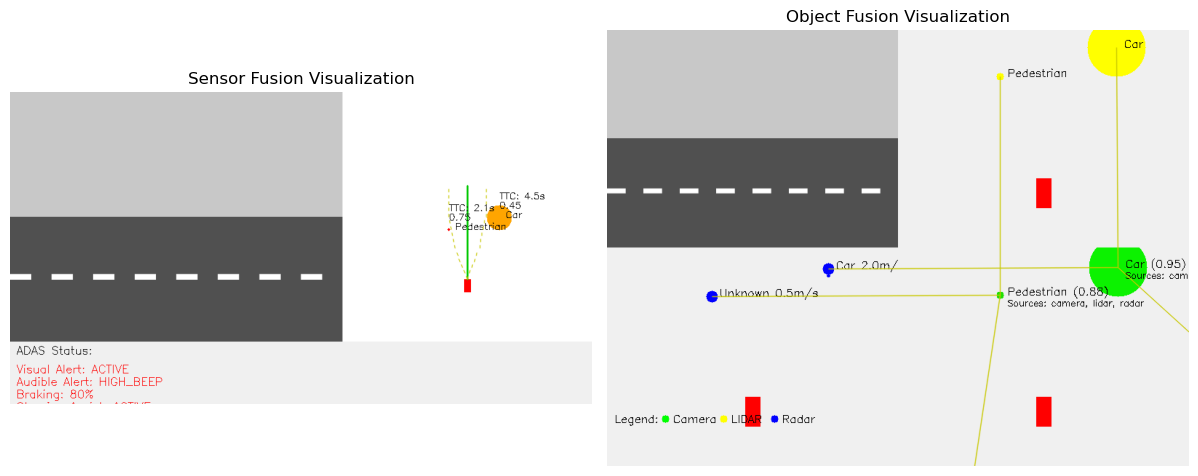

ADAS Actions:
- Visual Alert: ACTIVE
- Audible Alert: HIGH_BEEP
- Braking: 80%
- Steering Assist: ACTIVE


In [27]:
# Create sample data for testing
def create_sample_data():
    # Sample camera image (create a dummy road image)
    camera_image = np.ones((480, 640, 3), dtype=np.uint8) * 200
    # Draw road
    cv2.rectangle(camera_image, (0, 240), (640, 480), (80, 80, 80), -1)
    # Draw lane markings
    for i in range(10):
        start_x = i * 80
        cv2.rectangle(camera_image, (start_x, 350), (start_x + 40, 360), (255, 255, 255), -1)
    
    # Sample objects
    camera_objects = [
        {'id': 'cam_1', 'type': 'Car', 'bbox': [320, 300, 380, 340], 'confidence': 0.92},
        {'id': 'cam_2', 'type': 'Pedestrian', 'bbox': [100, 320, 120, 370], 'confidence': 0.85}
    ]
    
    lidar_objects = [
        {'id': 'lidar_1', 'type': 'Car', 'position': [5, 10, 0], 'dimensions': [2, 4, 1.5], 'confidence': 0.9},
        {'id': 'lidar_2', 'type': 'Pedestrian', 'position': [-3, 8, 0], 'dimensions': [0.5, 0.5, 1.7], 'confidence': 0.8}
    ]
    
    radar_objects = [
        {'id': 'radar_1', 'type': 'Car', 'position': [5.2, 9.8, 0], 'velocity': [0, -2, 0], 'confidence': 0.85},
        {'id': 'radar_2', 'type': 'Unknown', 'position': [-2.8, 7.9, 0], 'velocity': [0.5, 0, 0], 'confidence': 0.7}
    ]
    
    fused_objects = [
        {
            'id': 'fused_1', 
            'type': 'Car', 
            'position': [5.1, 9.9, 0], 
            'dimensions': [2, 4, 1.5], 
            'velocity': [0, -2, 0], 
            'confidence': 0.95,
            'threat_level': 2,
            'sources': ['camera', 'lidar', 'radar'],
            'camera_id': 'cam_1',
            'lidar_id': 'lidar_1',
            'radar_id': 'radar_1'
        },
        {
            'id': 'fused_2', 
            'type': 'Pedestrian', 
            'position': [-3, 8, 0], 
            'dimensions': [0.5, 0.5, 1.7], 
            'velocity': [0.5, 0, 0], 
            'confidence': 0.88,
            'threat_level': 3,
            'sources': ['camera', 'lidar', 'radar'],
            'camera_id': 'cam_2',
            'lidar_id': 'lidar_2',
            'radar_id': 'radar_2'
        }
    ]
    
    collision_risks = [
        {
            'object': fused_objects[0],
            'probability': 0.45,
            'ttc': 4.5
        },
        {
            'object': fused_objects[1],
            'probability': 0.75,
            'ttc': 2.1
        }
    ]
    
    current_path = [
        {'x': 0, 'y': 0},
        {'x': 0, 'y': 5},
        {'x': 0, 'y': 10},
        {'x': 0, 'y': 15}
    ]
    
    alternative_paths = [
        [
            {'x': 0, 'y': 0},
            {'x': 2, 'y': 5},
            {'x': 3, 'y': 10},
            {'x': 3, 'y': 15}
        ],
        [
            {'x': 0, 'y': 0},
            {'x': -2, 'y': 5},
            {'x': -3, 'y': 10},
            {'x': -3, 'y': 15}
        ]
    ]
    
    return {
        'camera_image': camera_image,
        'camera_objects': camera_objects,
        'lidar_objects': lidar_objects,
        'radar_objects': radar_objects,
        'fused_objects': fused_objects,
        'collision_risks': collision_risks,
        'current_path': current_path,
        'alternative_paths': alternative_paths
    }

# Generate sample data
sample_data = create_sample_data()

# Test the sensor fusion visualization
fusion_vis, actions = visualize_sensor_fusion(
    sample_data['camera_image'],
    sample_data['fused_objects'],
    sample_data['collision_risks'],
    sample_data['current_path'],
    sample_data['alternative_paths']
)

# Test the object fusion visualization
object_fusion_vis = visualize_object_fusion(
    sample_data['camera_image'],
    sample_data['camera_objects'],
    sample_data['lidar_objects'],
    sample_data['radar_objects'],
    sample_data['fused_objects']
)

# Display the results

plt.figure(figsize=(30, 20))

plt.subplot(4, 5, 1)
plt.title('Sensor Fusion Visualization')
plt.imshow(cv2.cvtColor(fusion_vis, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(4, 5, 2)
plt.title('Object Fusion Visualization')
plt.imshow(cv2.cvtColor(object_fusion_vis, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()

# Print the actions taken by the ADAS system
print("ADAS Actions:")
for action in actions:
    print(f"- {action}")

In [16]:
def create_scenario(scenario_type="highway"):
    """
    Create different ADAS scenarios for testing
    
    Args:
        scenario_type: Type of scenario to create (highway, urban, emergency)
        
    Returns:
        Dictionary containing camera image and sensor data for the scenario
    """
    # Base camera image
    camera_image = np.ones((480, 640, 3), dtype=np.uint8) * 200
    
    if scenario_type == "highway":
        # Highway scene with multiple vehicles
        # Draw road (wider for highway)
        cv2.rectangle(camera_image, (0, 240), (640, 480), (80, 80, 80), -1)
        # Draw lane markings (more lanes for highway)
        for i in range(4):
            y_pos = 300 + i * 40
            for j in range(10):
                start_x = j * 80
                cv2.rectangle(camera_image, (start_x, y_pos), (start_x + 40, y_pos + 5), (255, 255, 255), -1)
        
        # Highway vehicles
        camera_objects = [
            {'id': 'cam_1', 'type': 'Car', 'bbox': [320, 300, 380, 330], 'confidence': 0.95},
            {'id': 'cam_2', 'type': 'Truck', 'bbox': [420, 290, 520, 340], 'confidence': 0.92},
            {'id': 'cam_3', 'type': 'Car', 'bbox': [200, 310, 250, 335], 'confidence': 0.88},
            {'id': 'cam_4', 'type': 'Car', 'bbox': [100, 320, 150, 340], 'confidence': 0.85}
        ]
        
        lidar_objects = [
            {'id': 'lidar_1', 'type': 'Car', 'position': [15, 0, 0], 'dimensions': [2, 4, 1.5], 'confidence': 0.9},
            {'id': 'lidar_2', 'type': 'Truck', 'position': [25, 3, 0], 'dimensions': [2.5, 8, 3], 'confidence': 0.95},
            {'id': 'lidar_3', 'type': 'Car', 'position': [10, -2, 0], 'dimensions': [2, 4, 1.5], 'confidence': 0.85},
            {'id': 'lidar_4', 'type': 'Car', 'position': [5, -4, 0], 'dimensions': [2, 4, 1.5], 'confidence': 0.8}
        ]
        
        radar_objects = [
            {'id': 'radar_1', 'type': 'Car', 'position': [15.2, 0.1, 0], 'velocity': [-5, 0, 0], 'confidence': 0.85},
            {'id': 'radar_2', 'type': 'Truck', 'position': [25.1, 3.2, 0], 'velocity': [-3, 0, 0], 'confidence': 0.9},
            {'id': 'radar_3', 'type': 'Car', 'position': [10.3, -1.9, 0], 'velocity': [-6, 0.2, 0], 'confidence': 0.8},
            {'id': 'radar_4', 'type': 'Car', 'position': [5.1, -4.1, 0], 'velocity': [-4.5, -0.1, 0], 'confidence': 0.75}
        ]
        
        # Create fused objects
        fused_objects = []
        for i in range(4):
            fused_objects.append({
                'id': f'fused_{i+1}',
                'type': lidar_objects[i]['type'],
                'position': [
                    (lidar_objects[i]['position'][0] + radar_objects[i]['position'][0]) / 2,
                    (lidar_objects[i]['position'][1] + radar_objects[i]['position'][1]) / 2,
                    0
                ],
                'dimensions': lidar_objects[i]['dimensions'],
                'velocity': radar_objects[i]['velocity'],
                'confidence': (lidar_objects[i]['confidence'] + radar_objects[i]['confidence'] + camera_objects[i]['confidence']) / 3,
                'threat_level': 1 if i != 1 else 2,  # Higher threat for truck
                'sources': ['camera', 'lidar', 'radar'],
                'camera_id': camera_objects[i]['id'],
                'lidar_id': lidar_objects[i]['id'],
                'radar_id': radar_objects[i]['id']
            })
        
        # Highway collision risks (generally lower)
        collision_risks = [
            {
                'object': fused_objects[1],  # Truck
                'probability': 0.35,
                'ttc': 8.3
            },
            {
                'object': fused_objects[2],  # Car on left
                'probability': 0.15,
                'ttc': 5.2
            }
        ]
        
        # Highway path (straight with slight lane changes)
        current_path = [
            {'x': 0, 'y': 0},
            {'x': 0, 'y': 10},
            {'x': 0.5, 'y': 20},
            {'x': 1, 'y': 30},
            {'x': 1, 'y': 40}
        ]
        
        alternative_paths = [
            [
                {'x': 0, 'y': 0},
                {'x': 1, 'y': 10},
                {'x': 3, 'y': 20},
                {'x': 4, 'y': 30},
                {'x': 4, 'y': 40}
            ],
            [
                {'x': 0, 'y': 0},
                {'x': -1, 'y': 10},
                {'x': -3, 'y': 20},
                {'x': -4, 'y': 30},
                {'x': -4, 'y': 40}
            ]
        ]
        
    elif scenario_type == "urban":
      # Urban scene with pedestrians, cyclists, and cars
        # Draw road
        cv2.rectangle(camera_image, (0, 240), (640, 480), (80, 80, 80), -1)
        # Draw lane markings
        for i in range(2):
            y_pos = 320 + i * 40
            for j in range(10):
                start_x = j * 80
                cv2.rectangle(camera_image, (start_x, y_pos), (start_x + 40, y_pos + 5), (255, 255, 255), -1)
        
        # Draw sidewalk
        cv2.rectangle(camera_image, (0, 200), (640, 240), (150, 150, 150), -1)
        
        # Urban objects
        camera_objects = [
            {'id': 'cam_1', 'type': 'Car', 'bbox': [350, 300, 420, 340], 'confidence': 0.9},
            {'id': 'cam_2', 'type': 'Pedestrian', 'bbox': [150, 230, 170, 280], 'confidence': 0.85},
            {'id': 'cam_3', 'type': 'Cyclist', 'bbox': [250, 250, 280, 300], 'confidence': 0.82},
            {'id': 'cam_4', 'type': 'Pedestrian', 'bbox': [100, 220, 120, 270], 'confidence': 0.88}
        ]
        
        lidar_objects = [
            {'id': 'lidar_1', 'type': 'Car', 'position': [8, 1, 0], 'dimensions': [2, 4, 1.5], 'confidence': 0.88},
            {'id': 'lidar_2', 'type': 'Pedestrian', 'position': [4, -3, 0], 'dimensions': [0.5, 0.5, 1.7], 'confidence': 0.82},
            {'id': 'lidar_3', 'type': 'Cyclist', 'position': [6, -2, 0], 'dimensions': [0.7, 1.8, 1.7], 'confidence': 0.8},
            {'id': 'lidar_4', 'type': 'Pedestrian', 'position': [3, -4, 0], 'dimensions': [0.5, 0.5, 1.7], 'confidence': 0.85}
        ]
        
        radar_objects = [
            {'id': 'radar_1', 'type': 'Car', 'position': [8.2, 0.9, 0], 'velocity': [-2, 0, 0], 'confidence': 0.85},
            {'id': 'radar_2', 'type': 'Unknown', 'position': [4.1, -3.1, 0], 'velocity': [0, 0.5, 0], 'confidence': 0.7},
            {'id': 'radar_3', 'type': 'Unknown', 'position': [6.1, -2.2, 0], 'velocity': [-1, 0, 0], 'confidence': 0.75},
            {'id': 'radar_4', 'type': 'Unknown', 'position': [3.2, -4.1, 0], 'velocity': [0.5, 0, 0], 'confidence': 0.7}
        ]
        
        # Create fused objects
        fused_objects = []
        for i in range(4):
            fused_objects.append({
                'id': f'fused_{i+1}',
                'type': camera_objects[i]['type'],  # Use camera classification
                'position': [
                    (lidar_objects[i]['position'][0] + radar_objects[i]['position'][0]) / 2,
                    (lidar_objects[i]['position'][1] + radar_objects[i]['position'][1]) / 2,
                    0
                ],
                'dimensions': lidar_objects[i]['dimensions'],
                'velocity': radar_objects[i]['velocity'],
                'confidence': (lidar_objects[i]['confidence'] + radar_objects[i]['confidence'] + camera_objects[i]['confidence']) / 3,
                'threat_level': 3 if i == 1 or i == 3 else 2,  # Higher threat for pedestrians
                'sources': ['camera', 'lidar', 'radar'],
                'camera_id': camera_objects[i]['id'],
                'lidar_id': lidar_objects[i]['id'],
                'radar_id': radar_objects[i]['id']
            })
        
        # Urban collision risks (higher for pedestrians)
        collision_risks = [
            {
                'object': fused_objects[1],  # Pedestrian
                'probability': 0.65,
                'ttc': 3.2
            },
            {
                'object': fused_objects[2],  # Cyclist
                'probability': 0.45,
                'ttc': 4.8
            },
            {
                'object': fused_objects[3],  # Pedestrian
                'probability': 0.55,
                'ttc': 2.5
            }
        ]
        
        # Urban path (more complex with turns)
        current_path = [
            {'x': 0, 'y': 0},
            {'x': 0, 'y': 5},
            {'x': 1, 'y': 10},
            {'x': 2, 'y': 15},
            {'x': 2, 'y': 20}
        ]
        
        alternative_paths = [
            [
                {'x': 0, 'y': 0},
                {'x': 1, 'y': 5},
                {'x': 3, 'y': 10},
                {'x': 4, 'y': 15},
                {'x': 4, 'y': 20}
            ],
            [
                {'x': 0, 'y': 0},
                {'x': -1, 'y': 5},
                {'x': -2, 'y': 10},
                {'x': -2, 'y': 15},
                {'x': -1, 'y': 20}
            ]
        ]
        
    elif scenario_type == "emergency":
        # Emergency scenario with high-risk objects
        # Draw road
        cv2.rectangle(camera_image, (0, 240), (640, 480), (80, 80, 80), -1)
        # Draw lane markings
        for i in range(2):
            y_pos = 320 + i * 40
            for j in range(10):
                start_x = j * 80
                cv2.rectangle(camera_image, (start_x, y_pos), (start_x + 40, y_pos + 5), (255, 255, 255), -1)
        
        # Emergency objects (car suddenly braking, pedestrian crossing)
        camera_objects = [
            {'id': 'cam_1', 'type': 'Car', 'bbox': [300, 300, 370, 340], 'confidence': 0.95},
            {'id': 'cam_2', 'type': 'Pedestrian', 'bbox': [400, 320, 420, 370], 'confidence': 0.9}
        ]
        
        lidar_objects = [
            {'id': 'lidar_1', 'type': 'Car', 'position': [6, 0, 0], 'dimensions': [2, 4, 1.5], 'confidence': 0.92},
            {'id': 'lidar_2', 'type': 'Pedestrian', 'position': [8, 2, 0], 'dimensions': [0.5, 0.5, 1.7], 'confidence': 0.88}
        ]
        
        radar_objects = [
            {'id': 'radar_1', 'type': 'Car', 'position': [6.1, 0.1, 0], 'velocity': [-8, 0, 0], 'confidence': 0.9},
            {'id': 'radar_2', 'type': 'Unknown', 'position': [8.2, 1.9, 0], 'velocity': [0, -3, 0], 'confidence': 0.85}
        ]
        
        # Create fused objects with high threat levels
        fused_objects = [
            {
                'id': 'fused_1',
                'type': 'Car',
                'position': [6.05, 0.05, 0],
                'dimensions': [2, 4, 1.5],
                'velocity': [-8, 0, 0],
                'confidence': 0.92,
                'threat_level': 4,  # Very high threat - sudden braking
                'sources': ['camera', 'lidar', 'radar'],
                'camera_id': 'cam_1',
                'lidar_id': 'lidar_1',
                'radar_id': 'radar_1'
            },
            {
                'id': 'fused_2',
                'type': 'Pedestrian',
                'position': [8.1, 1.95, 0],
                'dimensions': [0.5, 0.5, 1.7],
                'velocity': [0, -3, 0],
                'confidence': 0.88,
                'threat_level': 5,  # Extremely high threat - pedestrian crossing
                'sources': ['camera', 'lidar', 'radar'],
                'camera_id': 'cam_2',
                'lidar_id': 'lidar_2',
                'radar_id': 'radar_2'
            }
        ]
        
        # Emergency collision risks (very high)
        collision_risks = [
            {
                'object': fused_objects[0],  # Car braking
                'probability': 0.85,
                'ttc': 1.2
            },
            {
                'object': fused_objects[1],  # Pedestrian crossing
                'probability': 0.95,
                'ttc': 0.8
            }
        ]
        
        # Emergency path (emergency maneuver)
        current_path = [
            {'x': 0, 'y': 0},
            {'x': 0, 'y': 5},
            {'x': 0, 'y': 10}
        ]
        
        alternative_paths = [
            [
                {'x': 0, 'y': 0},
                {'x': 3, 'y': 3},
                {'x': 5, 'y': 6},
                {'x': 5, 'y': 10}
            ],
            [
                {'x': 0, 'y': 0},
                {'x': -3, 'y': 3},
                {'x': -5, 'y': 6},
                {'x': -5, 'y': 10}
            ]
        ]
    
    else:
        # Default to basic scenario if unknown type
        return create_sample_data()
    
    return {
        'camera_image': camera_image,
        'camera_objects': camera_objects,
        'lidar_objects': lidar_objects,
        'radar_objects': radar_objects,
        'fused_objects': fused_objects,
        'collision_risks': collision_risks,
        'current_path': current_path,
        'alternative_paths': alternative_paths
    }


Testing HIGHWAY scenario:


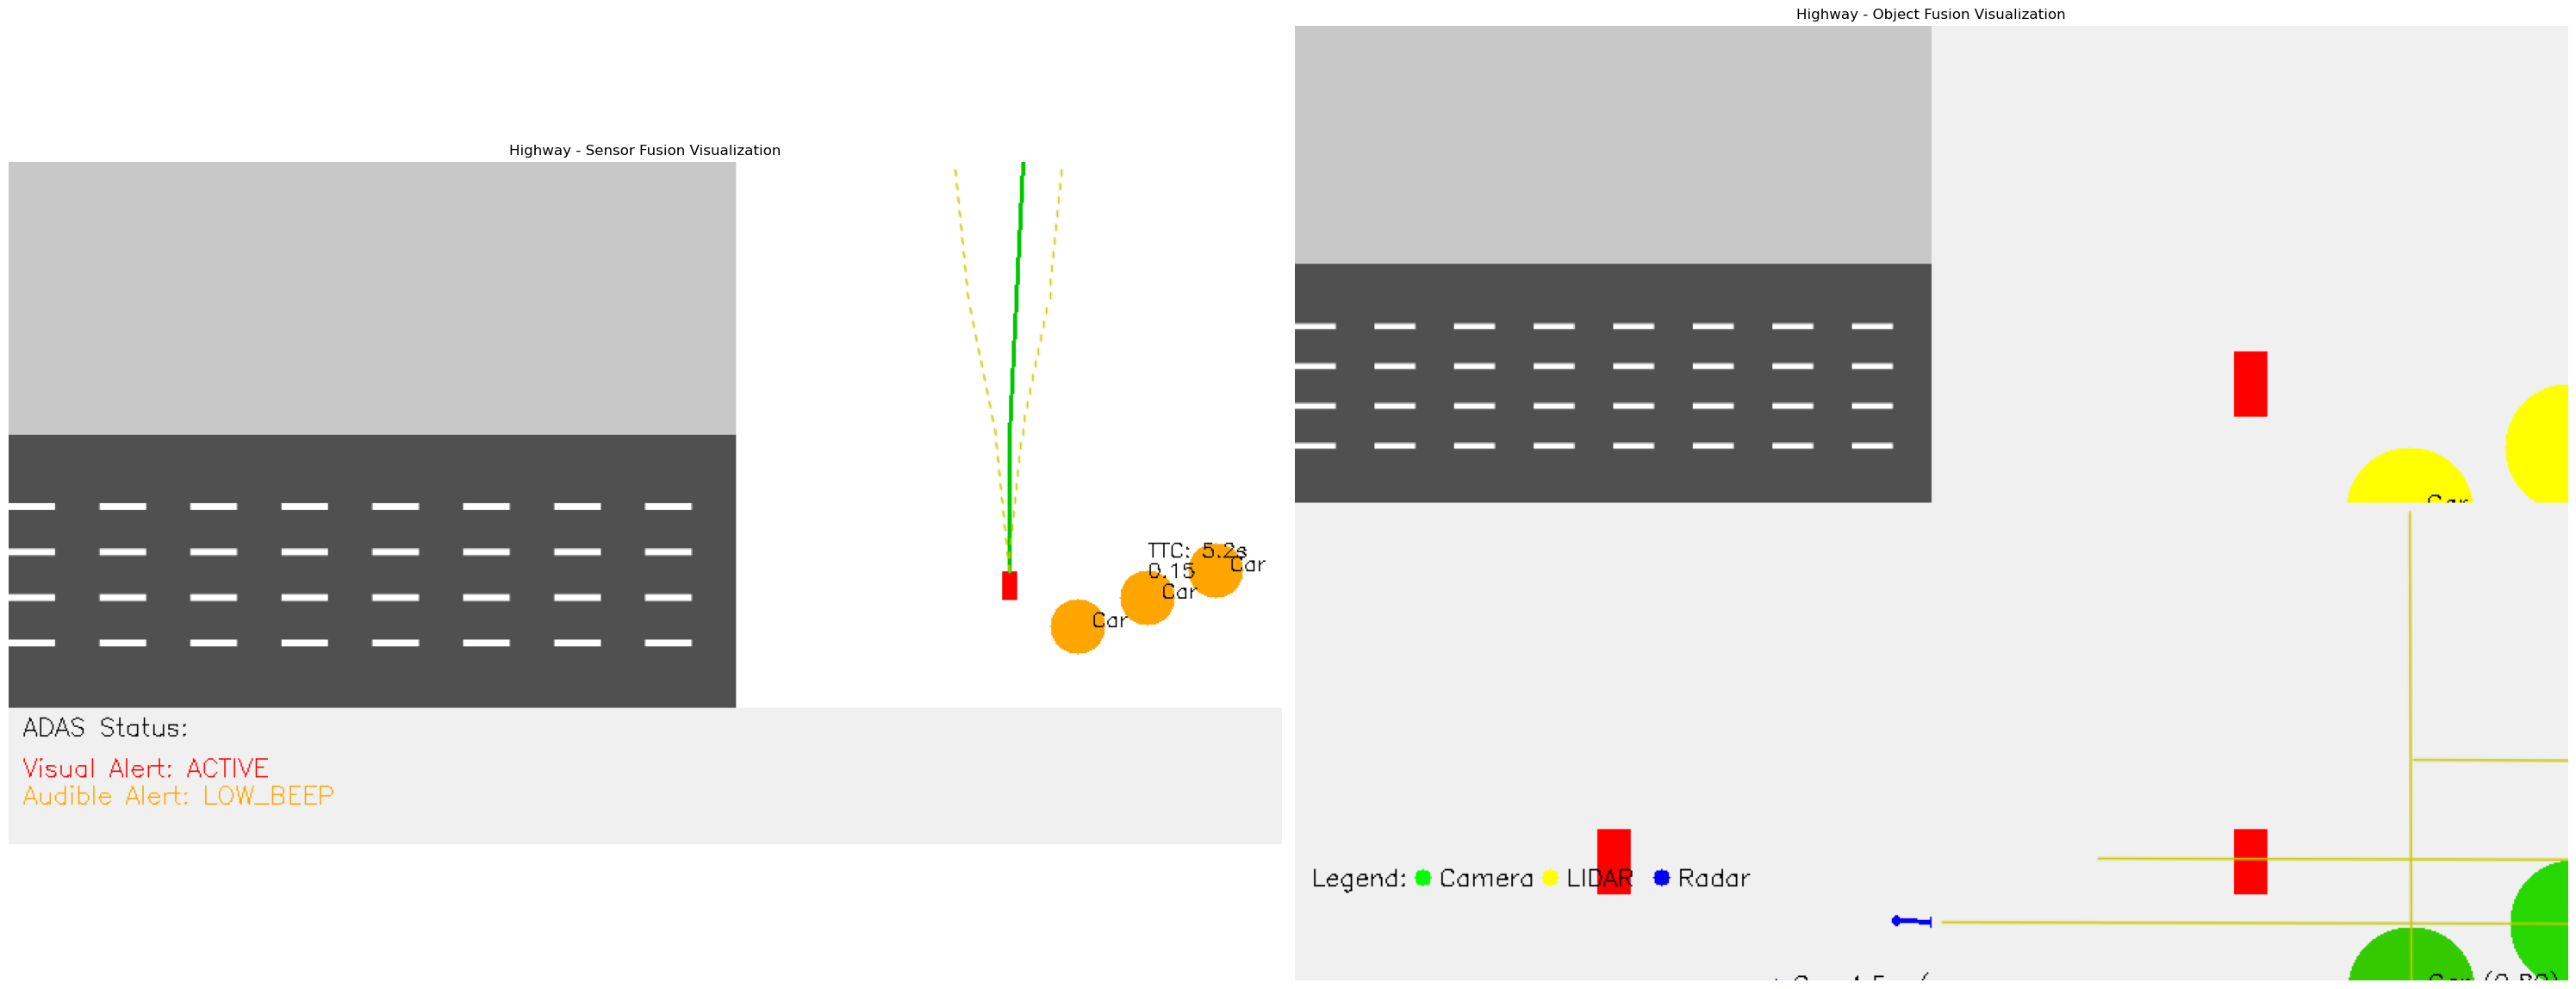

ADAS Actions for highway scenario:
- Visual Alert: ACTIVE
- Audible Alert: LOW_BEEP

Testing URBAN scenario:


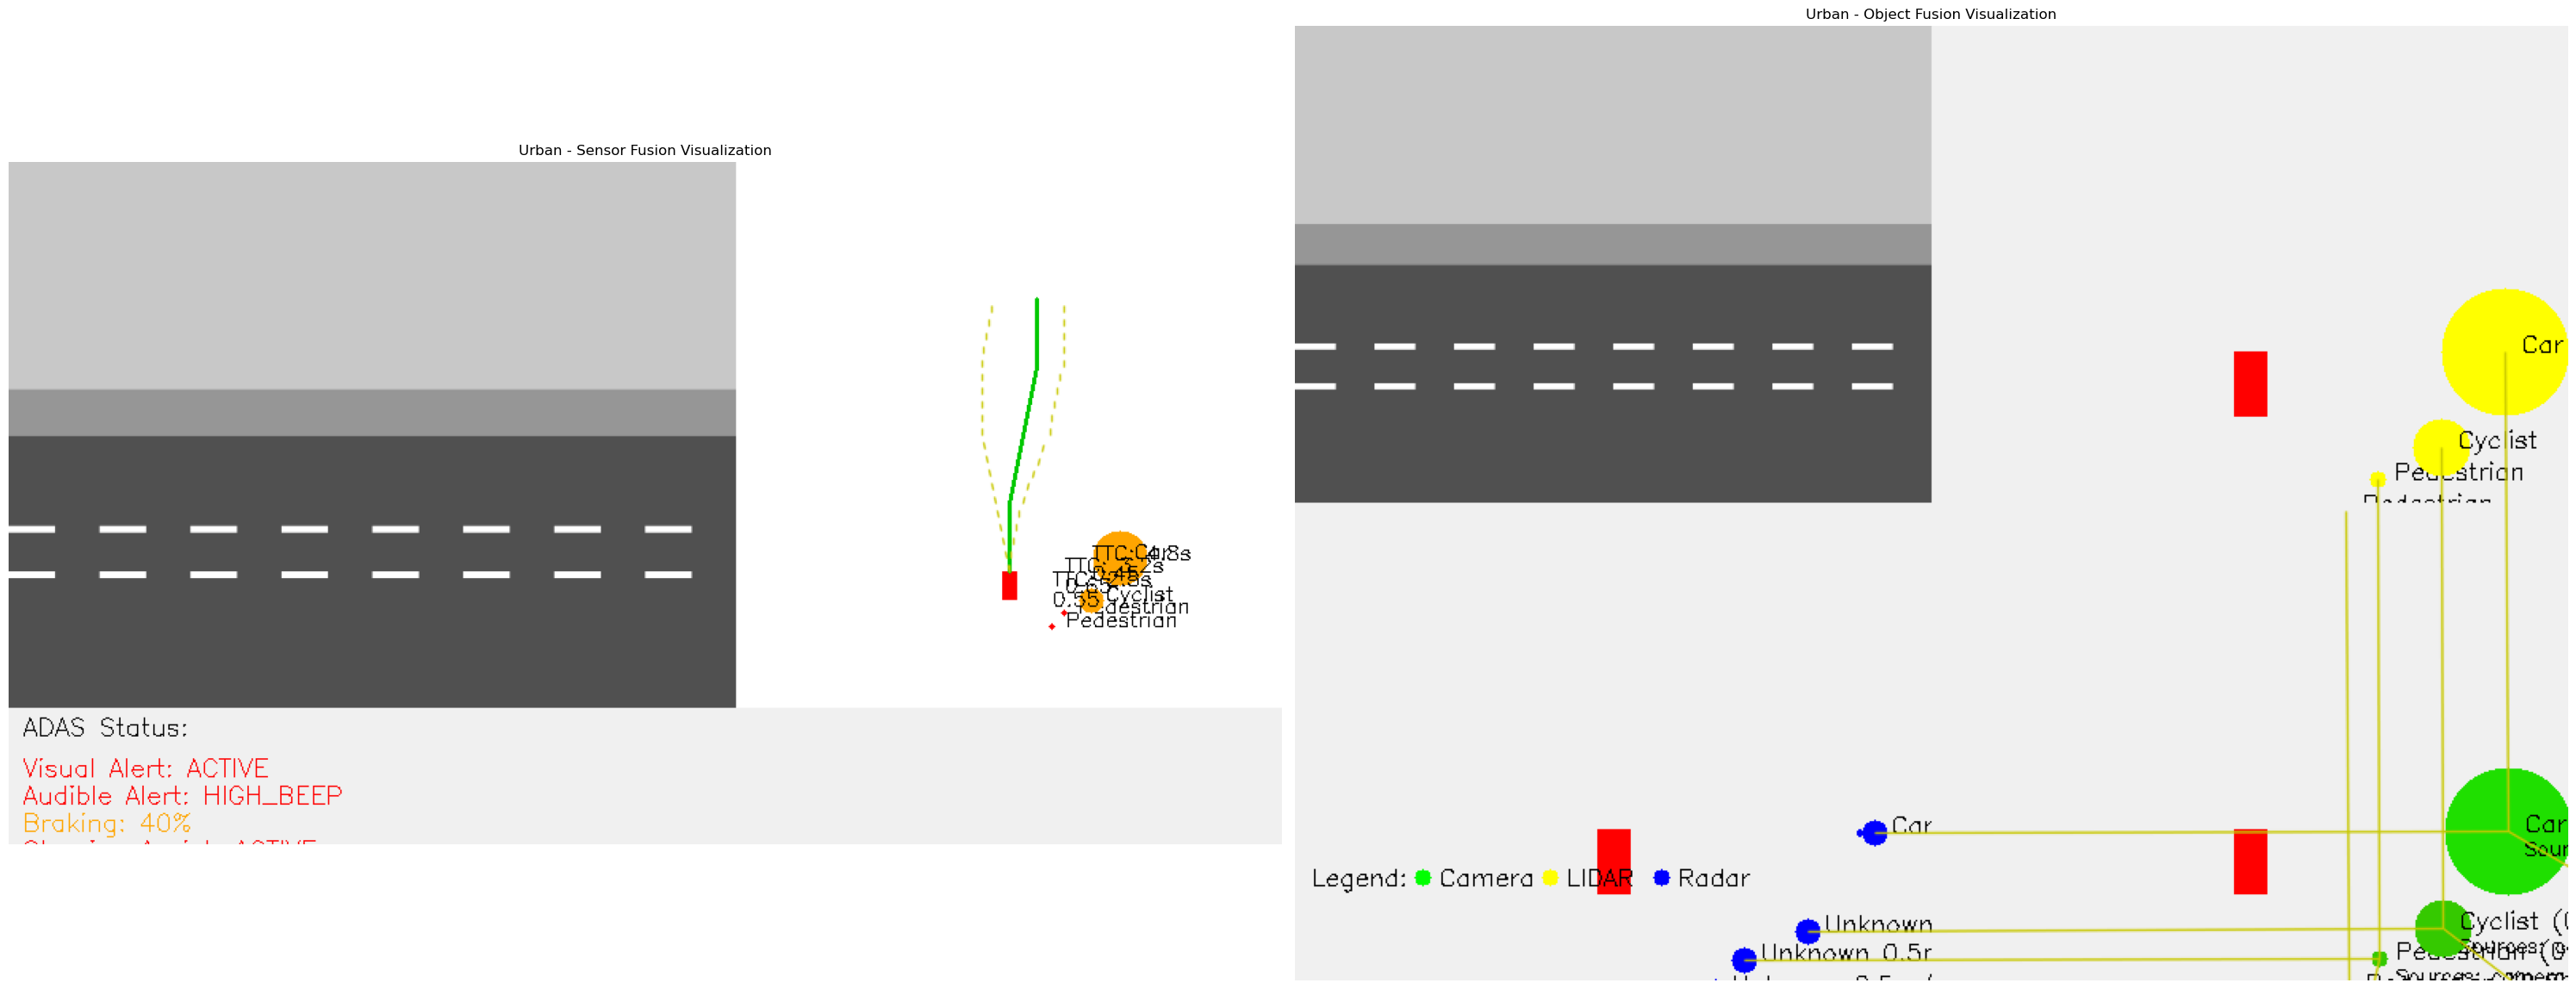

ADAS Actions for urban scenario:
- Visual Alert: ACTIVE
- Audible Alert: HIGH_BEEP
- Braking: 40%
- Steering Assist: ACTIVE

Testing EMERGENCY scenario:


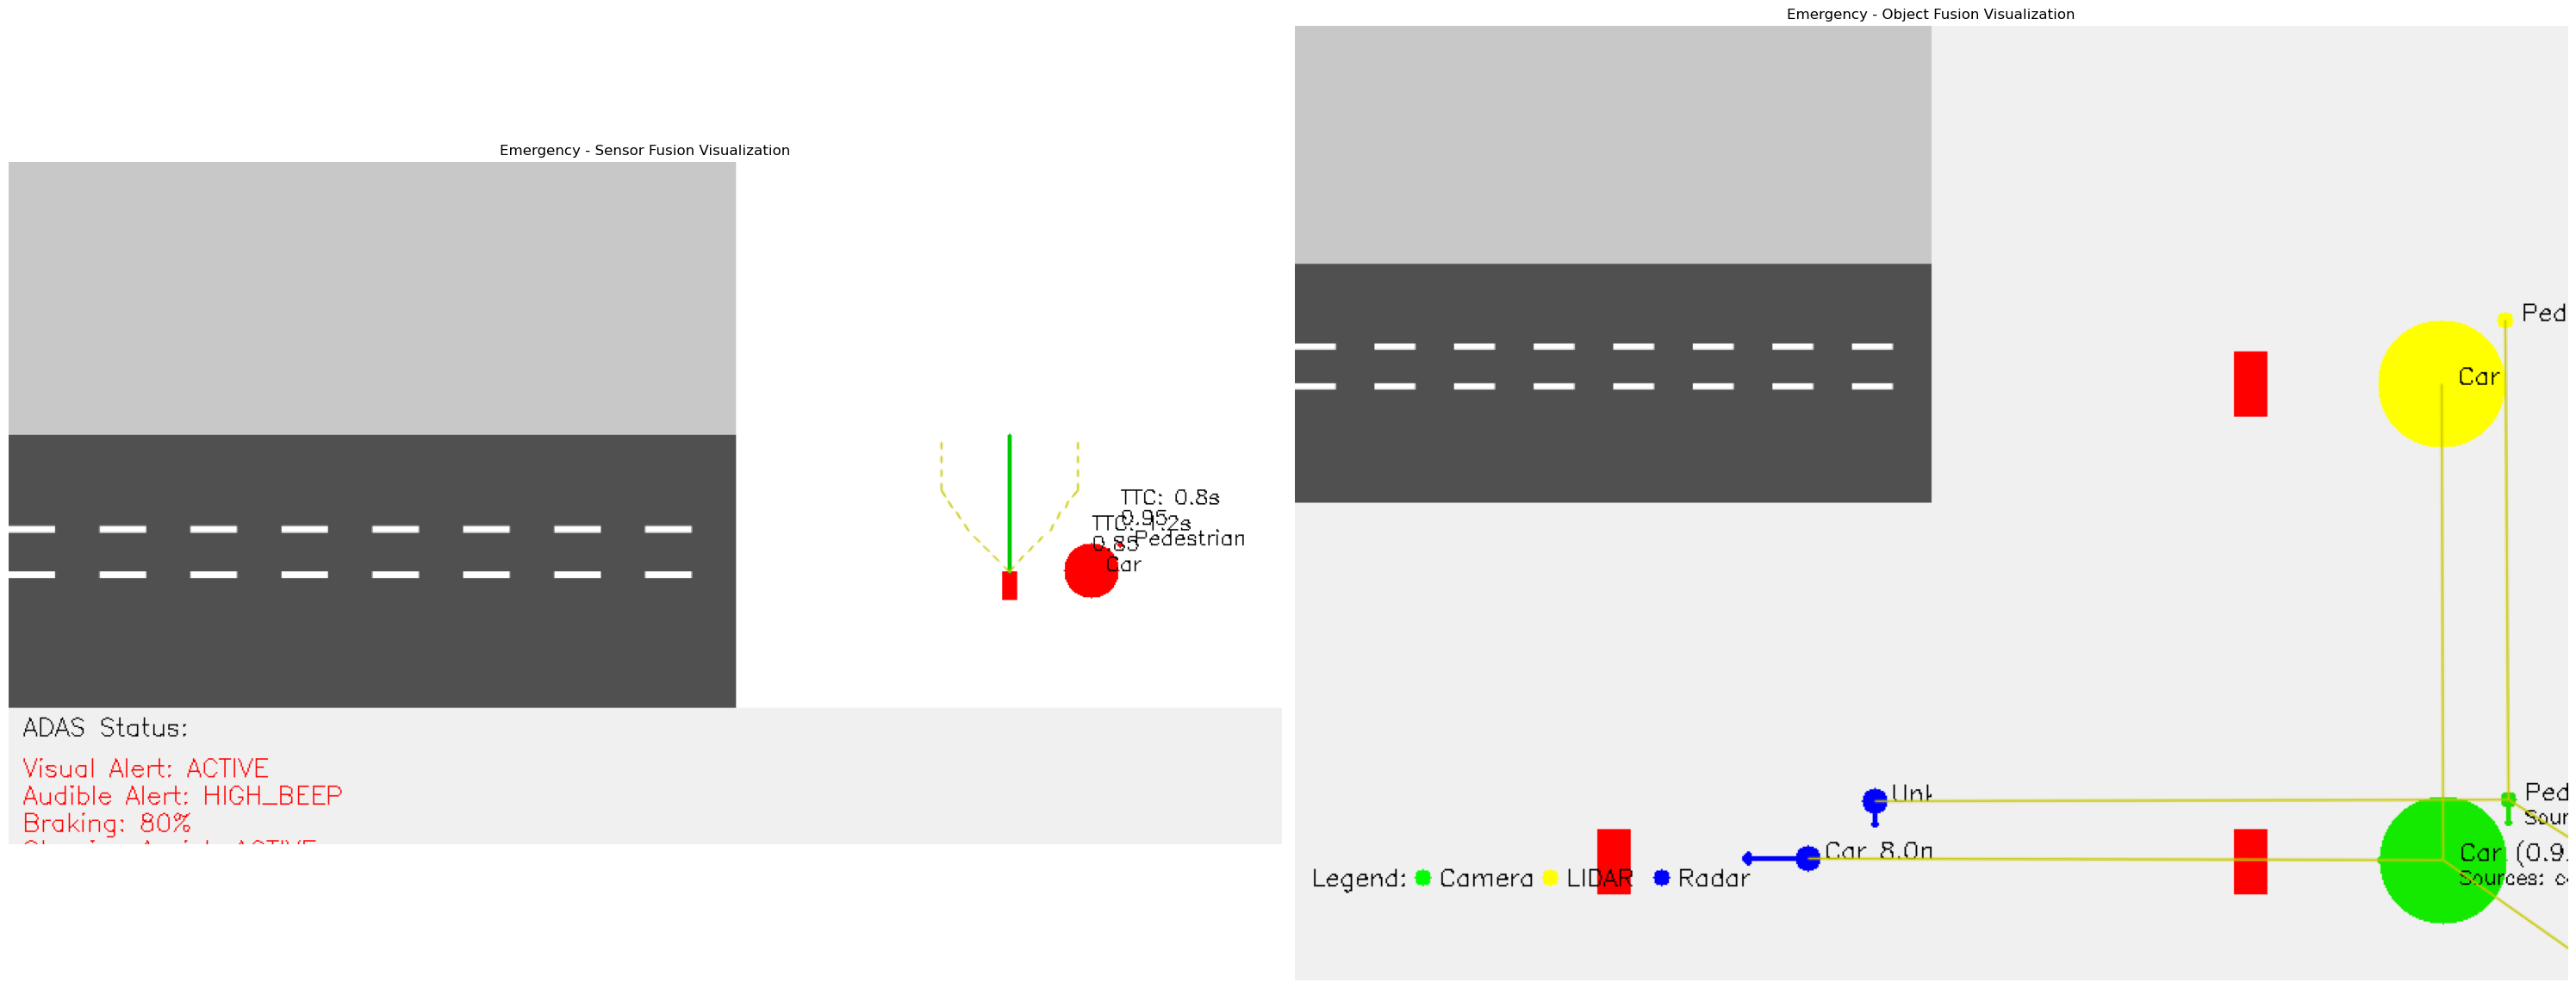

ADAS Actions for emergency scenario:
- Visual Alert: ACTIVE
- Audible Alert: HIGH_BEEP
- Braking: 80%
- Steering Assist: ACTIVE


In [20]:
scenarios = ["highway", "urban", "emergency"]

for scenario in scenarios:
    print(f"\nTesting {scenario.upper()} scenario:")
    
    # Generate scenario data
    scenario_data = create_scenario(scenario)
    
    # Test the sensor fusion visualization
    fusion_vis, actions = visualize_sensor_fusion(
        scenario_data['camera_image'],
        scenario_data['fused_objects'],
        scenario_data['collision_risks'],
        scenario_data['current_path'],
        scenario_data['alternative_paths']
    )
    
    # Test the object fusion visualization
    object_fusion_vis = visualize_object_fusion(
        scenario_data['camera_image'],
        scenario_data['camera_objects'],
        scenario_data['lidar_objects'],
        scenario_data['radar_objects'],
        scenario_data['fused_objects']
    )
    
    # Display the results
    plt.figure(figsize=(30, 20))
    
    plt.subplot(1, 2, 1)
    plt.title(f'{scenario.capitalize()} - Sensor Fusion Visualization')
    plt.imshow(cv2.cvtColor(fusion_vis, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title(f'{scenario.capitalize()} - Object Fusion Visualization')
    plt.imshow(cv2.cvtColor(object_fusion_vis, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print the actions taken by the ADAS system
    print(f"ADAS Actions for {scenario} scenario:")
    for action in actions:
        print(f"- {action}")